Outline:

1. Data processing and parsing
1. How to create a VIT from the GPT code
    1. Change to an encoder
    1. Handling the position embedding
    1. Binning the continuous values
1. Making A Multi-Modal Model for the Generalist Robotics Policy
    1. Adding the text goals
    1. Sanitising the data and standardization.
    1. Adding goal images
    1. Adding the input masking
1. Evaluating the model in sim
1. Recording videos of the results for evaluation

## Get full trajectories
Instead of a single image we want something that looks more like a sequence, similar to text. 
For robotics applications our "language" is images and actions.

### Load Datasets

The [data for](https://robotics-transformer-x.github.io/) robotics applications is often more complicated. There are images, actions and text descriptions. Also, the text descriptions is per episode, instead of at each frame, which is common for RL/BC.

In [ ]:
!git clone https://github.com/milarobotlearningcoursels/mini-grp.git
%cd mini-grp
!pip3 install -r requirements.txt

# Install repo
import cv2
import tensorflow_datasets as tfds
import tqdm
import rlds, numpy as np
import mediapy as media
from PIL import Image
from IPython import display

/home/gberseth/miniconda3/envs/roble/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-19 11:11:00.914805: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-19 11:11:01.167923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 11:11:01.168003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 11:

{'steps': <_VariantDataset element_spec={'action': {'open_gripper': TensorSpec(shape=(), dtype=tf.bool, name=None), 'rotation_delta': TensorSpec(shape=(3,), dtype=tf.float32, name=None), 'terminate_episode': TensorSpec(shape=(), dtype=tf.float32, name=None), 'world_vector': TensorSpec(shape=(3,), dtype=tf.float32, name=None)}, 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'observation': {'image': TensorSpec(shape=(480, 640, 3), dtype=tf.uint8, name=None), 'natural_language_embedding': TensorSpec(shape=(512,), dtype=tf.float32, name=None), 'natural_language_instruction': TensorSpec(shape=(), dtype=tf.string, name=None), 'state': TensorSpec(shape=(7,), dtype=tf.float32, name=None)}, 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}>}
Instruction: Place the can to the left of the pot.


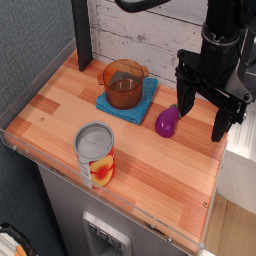

In [2]:
from PIL import Image
from IPython import display
import numpy as np
import cv2
import tensorflow_datasets as tfds
def as_gif(images, path='temp.png'):
  # Render the images as the gif:
  images = [Image.fromarray(image) for image in images]
  images[0].save(path, save_all=True, append_images=images[1:], duration=1000, loop=0)
  gif_bytes = open(path,'rb').read()
  return gif_bytes

# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
dataset = builder.as_dataset(split='train[:3]')

# sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(dataset))
print(episode)

steps = list(episode['steps'])
images = np.array([cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps])

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
display.Image(as_gif(images))

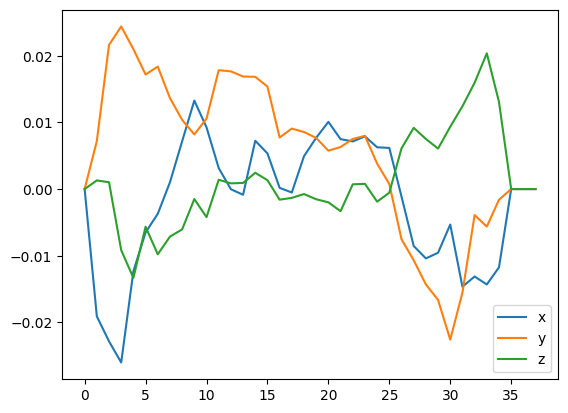

In [3]:
# %matplotlib inline
## Looking at the actions
# import matplotlib
# matplotlib.use('Agg')  # Set backend before importing pyplot
import matplotlib.pyplot as plt
# plt.rcdefaults()  # Reset matplotlib to defaults

actions = np.array([np.array(step['action']['world_vector']) for step in steps])
x = actions[:, 0]
plt.plot(actions[:, 0], label='x')
plt.plot(actions[:, 1], label='y')
plt.plot(actions[:, 2], label='z')
# plt.plot(actions[:, 3], label='x_rotation')
plt.legend()
plt.show()

## Validation in Simulation

Not everyone has a robot on their desk, and proof of concept evalauation in simulation is important. Here we are using the [SimpleEnv](https://simpler-env.github.io/) simualtor for evaluation of the trained model. I also, suggest people use [LIBERO](https://libero-project.github.io/intro.html) which is beocming more popular.

[2026-02-06 15:17:22.122] [svulkan2] [error] GLFW error: X11: The DISPLAY environment variable is missing
[2026-02-06 15:17:22.125] [svulkan2] [warning] Continue without GLFW.


Reset info {'scene_name': 'bridge_table_1_v1', 'scene_offset': None, 'scene_pose': None, 'scene_table_height': 0.87, 'urdf_version': '', 'rgb_overlay_path': '/home/mila/g/glen.berseth/playground/mini-grp/SimplerEnv/ManiSkill2_real2sim/data/real_inpainting/bridge_real_eval_1.png', 'rgb_overlay_cameras': ['3rd_view_camera'], 'rgb_overlay_mode': 'background', 'disable_bad_material': False, 'episode_model_ids': ['bridge_carrot_generated_modified', 'bridge_plate_objaverse_larger'], 'episode_model_scales': [1.0, 1.0], 'episode_source_obj_name': 'bridge_carrot_generated_modified', 'episode_target_obj_name': 'bridge_plate_objaverse_larger', 'episode_source_obj_init_pose_wrt_robot_base': Pose([0.381995, 0.104536, 0.0175282], [-0.706719, 0.0305475, -0.0305745, -0.706173]), 'episode_target_obj_init_pose_wrt_robot_base': Pose([0.382, -0.047, -0.000468433], [-6.55451e-07, -5.10228e-07, -1.6917e-06, -1]), 'episode_id': 1}
Instruction put carrot on plate
Episode stats OrderedDict([('moved_correct_obj

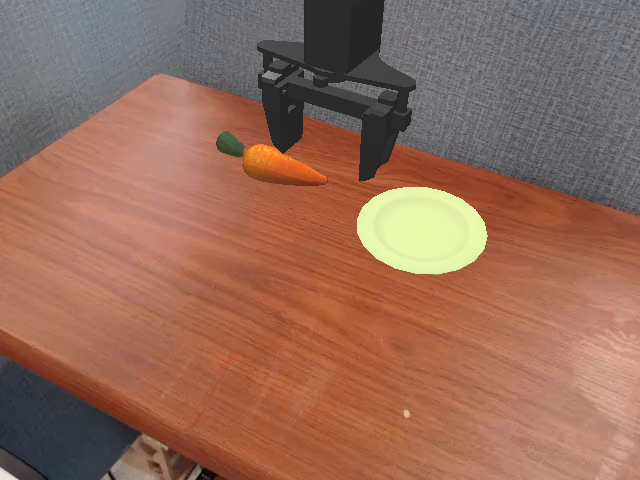

In [4]:
import simpler_env
from simpler_env.utils.env.observation_utils import get_image_from_maniskill2_obs_dict
import sapien.core as sapien
import matplotlib.pyplot as plt

task_name = "widowx_carrot_on_plate"  # @param ["google_robot_pick_coke_can", "google_robot_move_near", "google_robot_open_drawer", "google_robot_close_drawer", "widowx_spoon_on_towel", "widowx_carrot_on_plate", "widowx_stack_cube", "widowx_put_eggplant_in_basket"]

if 'env' in locals():
  print("Closing existing env")
  env.close()
  del env
env = simpler_env.make(task_name)
# Colab GPU does not support denoiser
sapien.render_config.rt_use_denoiser = False
obs, reset_info = env.reset()
instruction = env.env.env.env.get_language_instruction() # Need to unwrap gymnasium wrappers
print("Reset info", reset_info)
print("Instruction", instruction)

frames = []
done, truncated = False, False
while not (done or truncated):
   # action[:3]: delta xyz; action[3:6]: delta rotation in axis-angle representation;
   # action[6:7]: gripper (the meaning of open / close depends on robot URDF)
   image = get_image_from_maniskill2_obs_dict(env.env.env.env, obs)
   action = env.action_space.sample() # replace this with your policy inference
   obs, reward, done, truncated, info = env.step(action)
   frames.append(image)

episode_stats = info.get('episode_stats', {})
print("Episode stats", episode_stats)
# mediapy.show_video(frames, fps=10)
import moviepy.editor as mpy
clip = mpy.ImageSequenceClip(list(frames), fps=20)
display.Image(as_gif(frames))

In [6]:

## Grab a chunk of data for training
import tensorflow_datasets as tfds
import cv2
import numpy as np
image_shape = [64, 64, 3]
num_episodes = 20 ## How many episodes to grab from the dataset for training

builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
datasetRemote = builder.as_dataset(split='train[:' + str(num_episodes) + ']')
dataset = {"img": [], "action": [], "goal": [], "goal_img": [],
                "rotation_delta": [], "open_gripper": [] }
shortest_goal_txt = 10000000000
for episode in datasetRemote:
    episode_ = {'steps': [] }
    episode = list(episode['steps'])
    ## Goal image is just the last image/state/observation in the episode
    goal_img = cv2.resize(np.array(episode[-1]['observation']['image'], dtype=np.float32), (image_shape[0], image_shape[1]))
    for i in range(len(episode)):
        obs = cv2.resize(np.array(episode[i]['observation']['image'], dtype=np.float32), (image_shape[0], image_shape[1]))
        goal = episode[i]['observation']['natural_language_instruction'].numpy().decode()
        dataset["img"].append(obs)
        dataset["action"].append(np.array(np.concatenate((episode[i]['action']['world_vector'], 
                                                          episode[i]['action']['rotation_delta'],
                                                        [episode[i]['action']['open_gripper']]), axis=0)))
         
        dataset["rotation_delta"].append(np.array(episode[i]['action']['rotation_delta']))
        dataset["open_gripper"].append(np.array(episode[i]['action']['open_gripper']))
        dataset["goal"].append(goal)
        dataset["goal_img"].append(goal_img)
        if len(goal) < shortest_goal_txt: shortest_goal_txt = len(goal)

# here are all the unique characters that occur in this text
chars = sorted(list(set([item for row in dataset["goal"] for item in row])))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode_txt = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode_txy = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
print("vocab_size:", vocab_size)
print("example text encode:", encode_txt(dataset["goal"][0]))

print("Dataset shape:", len(dataset["img"]))
dataset["img"] = np.array(dataset["img"], dtype=np.uint8)
dataset["action"] = np.array(dataset["action"], dtype=np.float32)
# dataset["goal"] = np.array(encode_txt(dataset["goal"]), dtype=np.float32)
dataset["goal_img"] = np.array(dataset["goal_img"], dtype=np.uint8)


vocab_size: 31
example text encode: [6, 18, 8, 10, 12, 0, 25, 15, 12, 0, 10, 8, 20, 0, 25, 21, 0, 25, 15, 12, 0, 18, 12, 13, 25, 0, 21, 13, 0, 25, 15, 12, 0, 22, 21, 25, 2]
Dataset shape: 687


# How to create a VIT from the Transformer (NanoGPT) code
We have some familiarity with a robotics dataset. It contains multiple types of inputs, text and images and outputs, continuous values We need to make a model that will process in the input data and output the correct values depending on the input observation (img) and goal (text or image). I am going to extend some of [Karpathi](https://www.youtube.com/watch?v=kCc8FmEb1nY)'s [gpt-nano](https://github.com/karpathy/ng-video-lecture) code to keep as much of the model and details visable as we learn about this process. We will start with creating a [vision transformer](https://arxiv.org/abs/2010.11929) from the code.

In [9]:
## Need to adjust the masking. 
# We can have fully connected attention (encoder) or partially attended transformers. 
# Need to discuss this because we are going to modify this a couple times for our GRP.
# For images we want an encoder
import torch
import torch.nn as nn
from torch.nn import functional as F
# Self-attention
torch.manual_seed(1338)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# One head self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False) ## Here is what I am interested in
query = nn.Linear(C, head_size, bias=False) ## This is what I have
value = nn.Linear(C, head_size, bias=False) ## Here is what I will communicate if you find me useful
k = key(x)   # (B, T, 32)
q = query(x) # (B, T, 32)
wei =  q @ k.transpose(-2, -1) # (B, T, 32) @ (B, 32, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T,T))
# wei = wei.masked_fill(tril == 0, float('-inf')) ## Remove this to make an encoder
wei = F.softmax(wei, dim=-1) ## This normalizes the values for a good distribution (sum to 1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [10]:
## Look at the attension for one head
wei[0]

tensor([[0.0547, 0.2496, 0.2920, 0.0213, 0.2695, 0.0832, 0.0150, 0.0147],
        [0.0864, 0.1324, 0.5566, 0.0288, 0.0480, 0.0341, 0.0591, 0.0546],
        [0.0643, 0.1419, 0.0258, 0.1463, 0.2315, 0.1400, 0.1091, 0.1410],
        [0.0202, 0.5542, 0.0326, 0.0798, 0.0211, 0.1301, 0.0716, 0.0905],
        [0.0137, 0.0712, 0.0282, 0.0316, 0.0240, 0.3659, 0.3858, 0.0797],
        [0.3148, 0.0487, 0.0856, 0.0663, 0.0820, 0.0123, 0.1001, 0.2902],
        [0.0229, 0.0407, 0.1733, 0.0447, 0.0712, 0.4318, 0.1762, 0.0392],
        [0.3700, 0.0179, 0.0431, 0.2021, 0.2487, 0.0472, 0.0671, 0.0038]],
       grad_fn=<SelectBackward0>)

## Vision transformer Code

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F

## This is an encoder head with full attention 
class Head(nn.Module):
    
    def __init__(self, head_size, n_embd, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        # wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T) ## Remove masking
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ Create multiple heads for self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd=n_embd, dropout=dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication then computation """

    def __init__(self, n_embd, n_head, dropout):
        ## n_embd: embedding dimension, n_head: the number of heads we want
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd=n_embd, dropout=dropout)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


## Tokenizing Images
Transformers process tokens. The nano GPT model was designed to treat each letter as an individual token and train a model to continue outputing more tokens given a recent context of tokens. However most LLMs break up words into phonemes and pieces of words in a particular way to both represent the possible components of words well and keep the number of possible tokens within a reasonable number. This asks the question, how to tokenize an image? We litterally chop the image into $m$ equally sized __patches__.

In [12]:
def get_patches_fast(images):
    from einops import rearrange
    batch_size, height, width, channels = images.shape
    patch_size = 8 # cfg.patch_size ## n_patches = 8

    patches = rearrange(images[:,:,:,:3], 'b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size)
    if channels > 3:
        ## History stacking in the channel dimension for observations only, not goal images.
        patches = rearrange(images, 'b (h p1) (w p2) (c hs) -> b (h w hs) (p1 p2 c)', p1 = patch_size, p2 = patch_size, hs=cfg.policy.obs_stacking) ## Stack the history in the channel dimension
    return patches

Testing get_patches_fast...
Image shape: (64, 64, 3)
Patch shape: (192,)


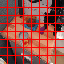

In [13]:
# image = get_patches_fast(torch.tensor(np.array(dataset["img"][:5])))
# out[0]

print('Testing get_patches_fast...')
## print out image shape
print("Image shape:", dataset["img"][0].shape)
out = get_patches_fast(torch.tensor(dataset["img"][:5]))
out[0].shape
# out[0]
## display the first patch
from IPython import display
patch = out[0][0].cpu().numpy().astype(np.uint8)
print("Patch shape:", patch.shape)
image = patch.reshape(8,8,3)
cv2.imwrite('temp_patch.png', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
display.display(display.Image('temp_patch.png'))
### Display the patches put back together with a line between the patches
from einops import rearrange
reconstructed = rearrange(out[0], ' (h w) (p1 p2 c) -> (h p1) (w p2) c', h=8, w=8, p1=8, p2=8, c=3).cpu().numpy().astype(np.uint8)
# Add lines between patches
line_color = [255, 0, 0]  # Red lines
for i in range(1, 8):
    reconstructed[i*8-1:i*8, :, :] = line_color
    reconstructed[:, i*8-1:i*8, :] = line_color
cv2.imwrite('reconstructed_with_lines.png', cv2.cvtColor(reconstructed, cv2.COLOR_RGB2BGR))
display.display(display.Image('reconstructed_with_lines.png'))  

### Compute the Position Embeddings

These embeddings help the transformer keep track of where items are located in the image.

In [14]:
def calc_positional_embeddings(sequence_length, d):
    out = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            out[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return out

In [15]:
## Helper routines to simple training.

# data loading
def get_batch_vit(split, dataset, batch_size):
    # generate a small batch of inputs x and targets y
    data = dataset
    ix = np.random.randint(int(len(data["img"])), size=(batch_size,))
    x = torch.tensor(data["img_enc"][ix], dtype=torch.float)
    y = torch.tensor(data["label"][ix], dtype=torch.long)
    return x, y

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(model._cfg.eval_iters)
        for k in range(model._cfg.eval_iters):
            X, Y = get_batch_vit(split, model._dataset, model._cfg.batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [16]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

import tensorflow_datasets as tfds
import numpy as np
from tqdm import tqdm, trange
import cv2


class VIT(nn.Module):
  def __init__(self, dataset, cfg, mlp_ratio=4):
    super(VIT, self).__init__()
    self._dataset = dataset
    self._cfg = cfg
    self.patch_size = (cfg.image_shape[0] / cfg.n_patches, cfg.image_shape[1] / cfg.n_patches)

    #Positional embedding
    self.register_buffer('positional_embeddings', calc_positional_embeddings(cfg.n_patches ** 2 + 1, cfg.n_embd), persistent=False)
    
    self.class_tokens = nn.Parameter(torch.rand(1, cfg.n_embd))

    self.input_d = int(cfg.image_shape[2] * self.patch_size[0] * self.patch_size[1])

    self.lin_map = nn.Linear(self.input_d, cfg.n_embd, bias=False) 

    # 4) Transformer encoder blocks
    self.blocks = nn.ModuleList([Block(cfg.n_embd, cfg.n_head, dropout=self._cfg.dropout) for _ in range(cfg.n_blocks)])

    # 5) Classification MLP
    self.mlp = nn.Sequential(
        nn.Linear(cfg.n_embd, cfg.action_bins),
        nn.Softmax(dim=-1)
    )

  def forward(self, images, targets=None):
    # Dividing images into patches
    n, c, h, w = images.shape
    patches = get_patches_fast(images)
    
    # Running linear layer tokenization
    # Map the vector corresponding to each patch to the hidden size dimension
    out = self.lin_map(patches)
    
    # Adding classification token to the tokens
    out = torch.cat((out, self.class_tokens.expand(n, 1, -1)), dim=1)
    
    # Adding positional embedding
    out = out + self.positional_embeddings.repeat(n, 1, 1)
    
    # Transformer Blocks
    for block in self.blocks:
        out = block(out)

    # Getting the classification token only
    out = out[:, -1]
    logits = self.mlp(out)
        
    if targets is None:
        loss = None
    else:
        # B,T,C = 4,8,2 # batch, time, channels
        B, C = logits.shape
        targets = targets.view(B)
        loss = F.cross_entropy(logits, targets)
    return (logits, loss)


In [18]:
## read the configuration yaml file and store that in the cfg object using Box
from box import Box
import yaml
with open('./conf/config.yaml', 'r') as f:
    cfg_dict = yaml.safe_load(f)
cfg = Box(cfg_dict)

In [19]:

def my_main():
    
    torch.manual_seed(cfg.r_seed)
    print ("cfg:", cfg)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    ## Make discrete labels from continuous actions use qcut
    dataset['label'] = torch.tensor(np.digitize(dataset['action'][:,:1], bins=np.linspace(np.min(dataset['action'][:,:1]), np.max(dataset['action'][:,:1]), cfg.action_bins - 1))).to(device)  
    dataset['img_enc'] = torch.tensor(dataset['img']).to(device)
    # dataset['label'] = torch.tensor(np.array(dataset['action'], dtype=np.uint8)).to(device)
    model = VIT(dataset, cfg)
    m = model.to(device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=float(cfg.learning_rate))

    for iter in range(cfg.max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % cfg.eval_interval == 0 or iter == cfg.max_iters - 1:
            losses = estimate_loss(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample a batch of data
        xb, yb = get_batch_vit('train', dataset, cfg.batch_size)

        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    return losses['val']

if __name__ == "__main__":
    import os
    results = my_main()
    print("results:", results)

cfg: {'defaults': [{'dataset': 'libero'}], 'experiment': {'name': 'mini_grp', 'project': 'mini-grp', 'description': 'simple env with 64pix images and pose data'}, 'model': {'type': 'transformer'}, 'batch_size': 64, 'max_block_size': 16, 'vocab_size': 32, 'n_patches': 8, 'patch_size': 8, 'max_iters': 25000, 'eval_interval': 100, 'learning_rate': '3e-4', 'lr_schedule': 'linear', 'eval_iters': 5, 'policy': {'action_stacking': 1, 'obs_stacking': 1, 'use_image_augmentations': False, 'dtype': 'float32', 'use_pose_data': 1, 'random_masking_enabled': False, 'use_last_action': False, 'add_noise_to_state': True, 'state_noise_std': 0.01}, 'testing': False, 'eval_vid_iters': 2500, 'gradient_accumulation_steps': 1, 'simEval': [], 'sim': {'eval_episodes': 1, 'eval_tasks': [0], 'episode length': 500, 'task_set': 'libero_spatial', 'libero_init_state_file': '/openvla/experiments/robot/libero/libero_spatial_init_states_and_goals.hdf', 'libero_init_state_hf_repo': 'gberseth/libero_spatial_init_states'}, 

  x = torch.tensor(data["img_enc"][ix], dtype=torch.float)

  y = torch.tensor(data["label"][ix], dtype=torch.long)



0.817159 M parameters
step 0: train loss 1.9719, val loss 1.9700
step 100: train loss 1.5154, val loss 1.5248
step 200: train loss 1.4967, val loss 1.5217
step 300: train loss 1.5123, val loss 1.5123
step 400: train loss 1.5623, val loss 1.5467
step 500: train loss 1.4998, val loss 1.4779
step 600: train loss 1.5654, val loss 1.5029
step 700: train loss 1.5248, val loss 1.4717
step 800: train loss 1.5029, val loss 1.5342
step 900: train loss 1.5060, val loss 1.5092
step 1000: train loss 1.5310, val loss 1.5498
step 1100: train loss 1.5185, val loss 1.5373
step 1200: train loss 1.5123, val loss 1.5060
step 1300: train loss 1.4810, val loss 1.5435
step 1400: train loss 1.4842, val loss 1.5373
step 1500: train loss 1.4779, val loss 1.5560
step 1600: train loss 1.5435, val loss 1.4998
step 1700: train loss 1.5029, val loss 1.4810
step 1800: train loss 1.5185, val loss 1.5092
step 1900: train loss 1.5279, val loss 1.4967
step 2000: train loss 1.5373, val loss 1.5185
step 2100: train loss 1.

Traceback (most recent call last):
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3215369/1607537458.py", line 40, in <module>
    results = my_main()
  File "/tmp/ipykernel_3215369/1607537458.py", line 31, in my_main
    logits, loss = model(xb, yb)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_3215369/498201927.py", line 56, in forward
    out = block(out)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapp

# Generalist Robotics Policies (GRPs)

Such as [Act](https://tonyzhaozh.github.io/aloha/) or [Octo](https://octo-models.github.io/). 
These models need multiple types of inputs.
(goal_text, goal_image, observation_img, robot_pose) -> GRP -> action
Let's start with adding text conditioning

## Adding text goals

In [20]:

class GRP(nn.Module):
  def __init__(self, dataset, cfg, mlp_ratio=4):
    super(GRP, self).__init__()
    self._dataset = dataset
    self._cfg = cfg

    ## Simple token embedding for goal text
    self.token_embedding_table = nn.Embedding(cfg.vocab_size, cfg.n_embd)
    self.patch_size = (self._cfg.image_shape[0] / self._cfg.n_patches, self._cfg.image_shape[1] / self._cfg.n_patches)

    #Positional embedding
    self.register_buffer('positional_embeddings', calc_positional_embeddings(1 + self._cfg.n_patches ** 2 + self._cfg.block_size, cfg.n_embd), persistent=False)
    
    self.class_tokens = nn.Parameter(torch.rand(1, cfg.n_embd))

    self.input_d = int(self._cfg.image_shape[2] * self.patch_size[0] * self.patch_size[1])

    self.lin_map = nn.Linear(self.input_d, self._cfg.n_embd, bias=False) 

    # 4) Transformer encoder blocks
    self.blocks = nn.ModuleList([Block(self._cfg.n_embd, self._cfg.n_head, dropout=self._cfg.dropout) for _ in range(self._cfg.n_blocks)])

    # 5) Classification MLPk
    self.mlp = nn.Sequential(
        nn.Linear(self._cfg.n_embd, self._cfg.action_bins),
        nn.Softmax(dim=-1)
    )

  def _init_weights(self, module):
      if isinstance(module, nn.Linear):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
          if module.bias is not None:
              torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, images, goals, targets=None):
    # Dividing images into patches
    n, c, h, w = images.shape
    patches = get_patches_fast(images)
    goals_e = self.token_embedding_table(goals)
    
    out = self.lin_map(patches)
    
    # Adding classification and goal_img tokens to the tokens
    out = torch.cat((out, goals_e, self.class_tokens.expand(n, 1, -1)), dim=1)
    
    # Adding positional embedding
    out = out + self.positional_embeddings.repeat(n, 1, 1)
    
    # Transformer Blocks
    for block in self.blocks:
        out = block(out)

    # Getting the classification token only
    out = out[:, -1]
    logits = self.mlp(out)
        
    if targets is None:
        loss = None
    else:
        B, C = logits.shape
        targets = targets.view(B)
        loss = F.cross_entropy(logits, targets)
    return (logits, loss)

In [21]:
## Helper routines to simple training.

# data loading
def get_batch_vit(split, dataset, batch_size):
    # generate a small batch of inputs x and targets y
    data = dataset['train'] if split == 'train' else dataset['test']
    ix = np.random.randint(int(len(data["img"])), size=(batch_size,))
    x = torch.tensor(data["img"][ix], dtype=torch.float)
    x_g = torch.tensor(data["goal"][ix], dtype=torch.long)
    y = torch.tensor(data["action"][ix], dtype=torch.long)
    return x, x_g, y

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(model._cfg.eval_iters)
        for k in range(model._cfg.eval_iters):
            X, G, Y = get_batch_vit(split, model._dataset, model._cfg.batch_size)
            logits, loss = model(X, G, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


In [22]:

import torch
import torch.nn as nn
from torch.nn import functional as F
from omegaconf import DictConfig, OmegaConf

def my_main():
    # from hydra import compose, initialize
    from box import Box
    import yaml
    with open('./conf/config.yaml', 'r') as f:
        cfg_dict = yaml.safe_load(f)
    cfg = Box(cfg_dict)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    cfg.block_size = shortest_goal_txt = min([len(txt) for txt in dataset["goal"]])

    # here are all the unique characters that occur in this text
    chars = sorted(list(set([item for row in dataset["goal"] for item in row]))) ## Flatten to a long string
    cfg.vocab_size = len(chars)
    # create a mapping from characters to integers
    stoi = { ch:i for i,ch in enumerate(chars) }
    itos = { i:ch for i,ch in enumerate(chars) }
    encode_txt = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
    decode_txy = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
    print("vocab_size:", cfg.vocab_size)
    print("example text encode:", encode_txt(dataset["goal"][0]))

    import pandas as pd
    action_labels = pd.qcut(np.reshape(dataset["action"][:,:1], (dataset["action"].shape[0])), cfg.action_bins, labels=False)
    hist, bin_edges = np.histogram(action_labels, density=True, bins=cfg.action_bins)
    print("action histogram:", hist)

    ## Get the states and encode them to map to [-1, 1]
    encode_state = lambda af:   ((af/(255.0)*2.0)-1.0).astype(np.float32) # encoder: take a float, output an integer
    resize_state = lambda sf:   cv2.resize(np.array(sf, dtype=np.float32), (cfg.image_shape[0], cfg.image_shape[1]))  # resize state

    ## Talk about Normalization and encoding for a bit
    dataset_tmp = {
        "img": torch.tensor(encode_state(dataset["img"])).to(device),
        "action": torch.tensor(np.reshape(action_labels, (dataset["action"].shape[0], 1)), dtype=torch.uint8).to(device),            
        "goal_img": torch.tensor(encode_state(dataset["goal_img"])).to(device),
        "goal": torch.tensor([encode_txt(goal[:shortest_goal_txt]) for goal in dataset["goal"]]).to(device)
    }

    print("Dataset shape:", len(dataset_tmp["img"]))
    dataset_tmp = {"train": dataset_tmp, "test": dataset_tmp} 

    model = GRP(dataset_tmp, cfg)
    model = model.to(device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=float(cfg.learning_rate))

    for iter in range(cfg.max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % cfg.eval_interval == 0 or iter == cfg.max_iters - 1:
            losses = estimate_loss(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample a batch of data
        xb, xg, yb = get_batch_vit('train', dataset_tmp, cfg.batch_size)

        # evaluate the loss
        logits, loss = model(xb, xg, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

if __name__ == "__main__":
    import os
    results = my_main()
    print("results:", results)

Using device:  cuda (Tesla V100-SXM2-32GB-LS)
vocab_size: 31
example text encode: [6, 18, 8, 10, 12, 0, 25, 15, 12, 0, 10, 8, 20, 0, 25, 21, 0, 25, 15, 12, 0, 18, 12, 13, 25, 0, 21, 13, 0, 25, 15, 12, 0, 22, 21, 25, 2]
action histogram: [0.16812227 0.16642407 0.16642407 0.16642407 0.16472586 0.16812227
 0.16642407]
Dataset shape: 687


  x = torch.tensor(data["img"][ix], dtype=torch.float)

  x_g = torch.tensor(data["goal"][ix], dtype=torch.long)

  y = torch.tensor(data["action"][ix], dtype=torch.long)



0.821127 M parameters
step 0: train loss 1.9477, val loss 1.9455
step 100: train loss 1.9251, val loss 1.9323
step 200: train loss 1.9272, val loss 1.9305
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3215369/3898254412.py", line 75, in <module>
    results = my_main()
  File "/tmp/ipykernel_3215369/3898254412.py", line 68, in my_main
    logits, loss = model(xb, xg, yb)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_3215369/3974321207.py", line 53, in forward
    out = block(out)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _

# A Note on Action Distributions

In robotics we have a choice of how we want to create the [action distribution](https://youtu.be/L3vDo3nLI98). It is possible to use realtive distance control, absolute, delta changes, and also the discretization. Right now, just binning the actions can be bad because of the distribution.

<div>
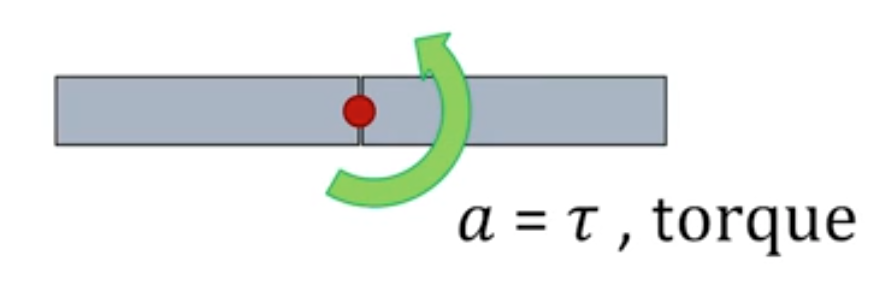
</div>

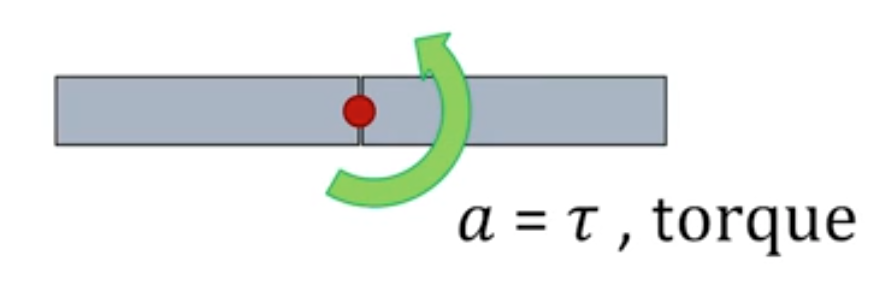
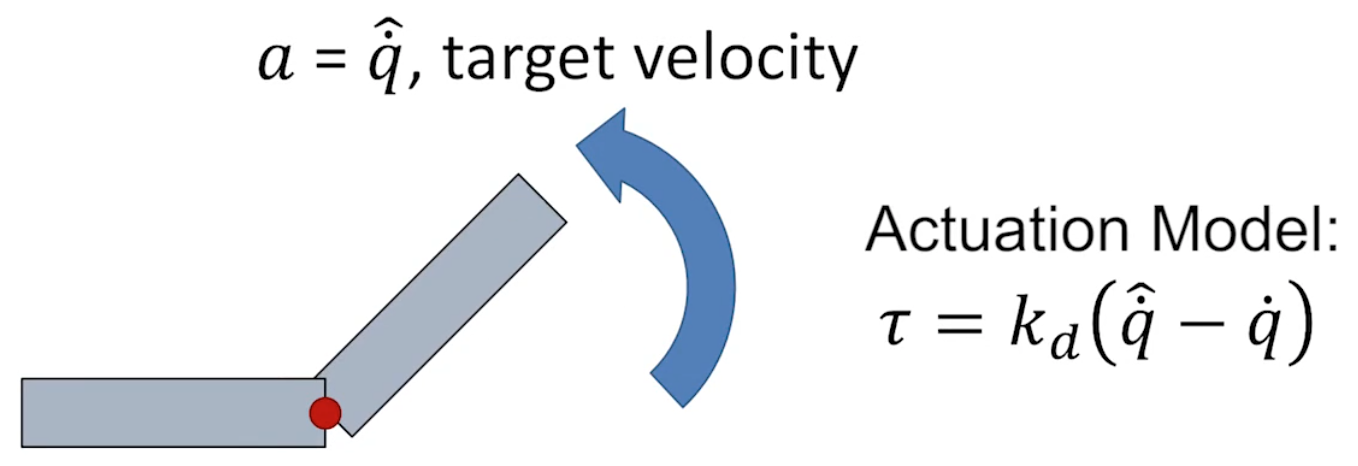
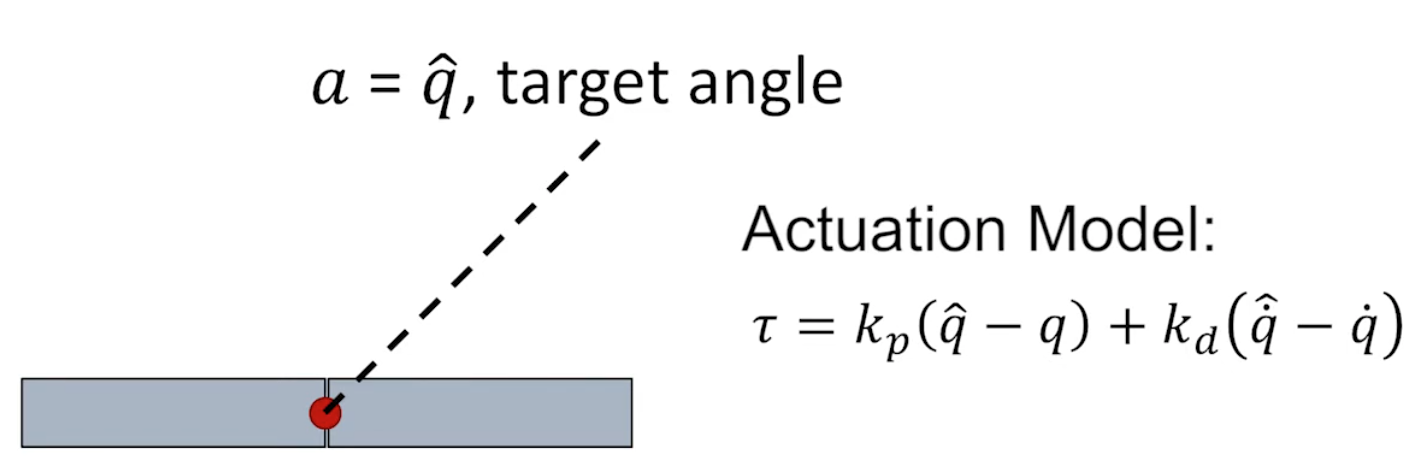
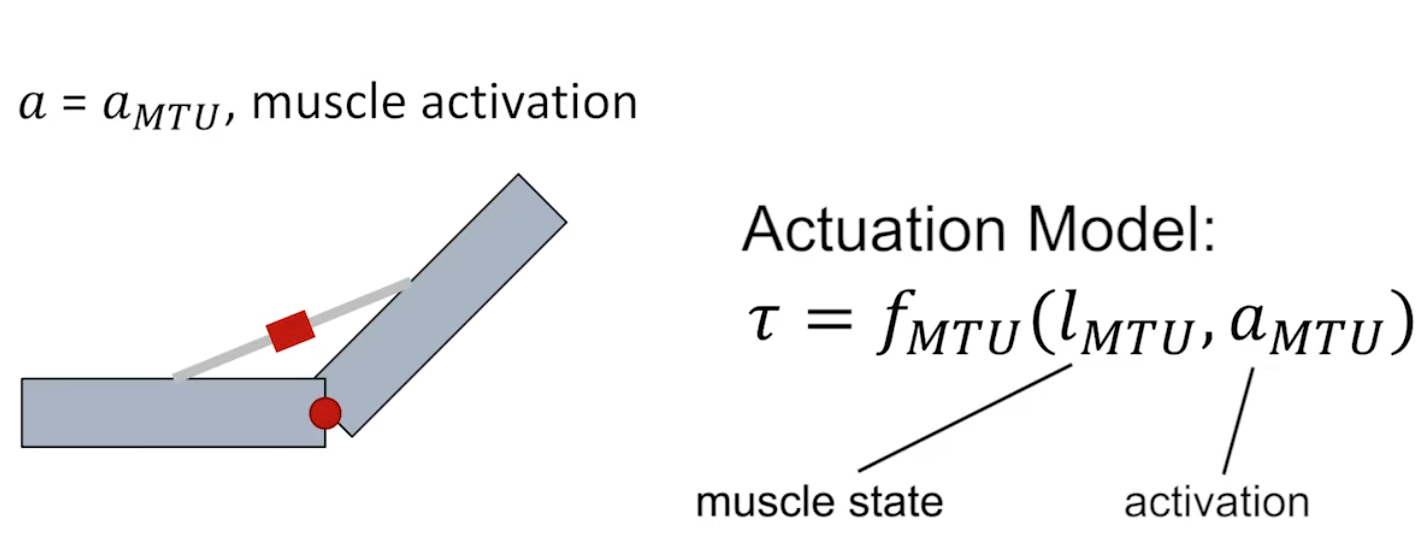

action histogram: [ 1.32285596  4.91346499  9.2599917  18.89794225 68.59953038 16.06325091
  7.93713575  1.7008148   0.56693827  0.56693827]


(array([  7.,  26.,  49., 100., 363.,  85.,  42.,   9.,   3.,   3.]),
 array([-0.03433708, -0.02663463, -0.01893218, -0.01122973, -0.00352729,
         0.00417516,  0.01187761,  0.01958006,  0.0272825 ,  0.03498495,
         0.0426874 ], dtype=float32),
 <BarContainer object of 10 artists>)

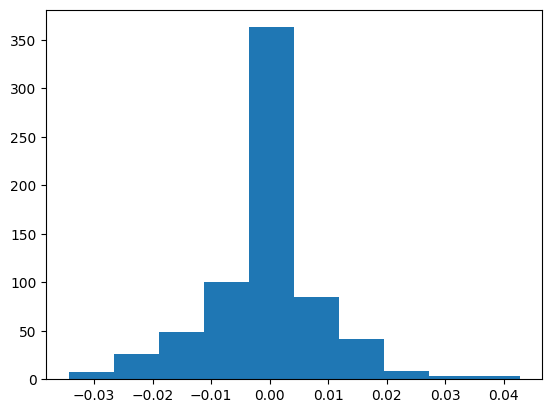

In [23]:
## Need to convert the continuous actions into discrete bins    
import matplotlib.pyplot as plt

hist, bin_edges = np.histogram(dataset['action'][:,0], density=True, bins=10)
print("action histogram:", hist)
# print("bin edges: ", bin_edges)
# plt.plot(hist)

#plot barplot of histograms
plt.hist(dataset['action'][:,0], bins=10)

## Continuous Actions
While the above model works so far it is not handeling action properly. Actions can be discrete, and often that helps get a well performing policy, however, the world is continuous and so are most robots. This is just a small change in loss function.


In [ ]:
loss = F.mse_loss(logits, targets)

In [25]:
class GRP(nn.Module):
  def __init__(self, dataset, cfg, mlp_ratio=4):
    super(GRP, self).__init__()
    self._dataset = dataset
    self._cfg = cfg

    self.token_embedding_table = nn.Embedding(cfg.vocab_size, cfg.n_embd)
    self.patch_size = (self._cfg.image_shape[0] / self._cfg.n_patches, self._cfg.image_shape[1] / self._cfg.n_patches)

    #Positional embedding
    self.register_buffer('positional_embeddings', calc_positional_embeddings(1 + self._cfg.n_patches ** 2 + 
                                                                             self._cfg.block_size, 
                                                                             self._cfg.n_embd), persistent=False)
    
    self.class_tokens = nn.Parameter(torch.rand(1, cfg.n_embd))

    self.input_d = int(self._cfg.image_shape[2] * self.patch_size[0] * self.patch_size[1])

    self.lin_map = nn.Linear(self.input_d, self._cfg.n_embd, bias=False) 

    # 4) Transformer encoder blocks
    self.blocks = nn.ModuleList([Block(self._cfg.n_embd, self._cfg.n_head, dropout=self._cfg.dropout) for _ in range(self._cfg.n_blocks)])

    # 5) Classification MLPk
    self.mlp = nn.Sequential(
        nn.Linear(self._cfg.n_embd, self._cfg.action_bins),
        nn.Softmax(dim=-1)
    )

  def _init_weights(self, module):
      if isinstance(module, nn.Linear):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
          if module.bias is not None:
              torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, images, goals, targets=None):
    # Dividing images into patches
    n, c, h, w = images.shape
    patches = get_patches_fast(images)
    goals_e = self.token_embedding_table(goals)
    
    # Running linear layer tokenization
    # Map the vector corresponding to each patch to the hidden size dimension
    out = self.lin_map(patches)
    
    # Adding classification and goal_img tokens to the tokens
    out = torch.cat((out, goals_e, self.class_tokens.expand(n, 1, -1)), dim=1)
    
    # Adding positional embedding
    out = out + self.positional_embeddings.repeat(n, 1, 1)
    
    # Transformer Blocks
    for block in self.blocks:
        out = block(out)

    # Getting the classification token only
    out = out[:, -1]
    out = self.mlp(out)
        
    if targets is None:
        loss = None
    else:
        B, C = out.shape
        loss = F.mse_loss(out, targets) ## B, C
    return (out, loss)


In [28]:
## Helper routines to simpel training.

# data loading
def get_batch_vit(split, dataset, batch_size):
    # generate a small batch of inputs x and targets y
    data = dataset
    ix = np.random.randint(int(len(data["image_enc"])), size=(batch_size,))
    x = torch.tensor(data["image_enc"][ix], dtype=torch.float)
    x_g = torch.tensor(data["goal_enc"][ix], dtype=torch.long)
    y = torch.tensor(data["action_enc"][ix], dtype=torch.float)
    # x, y = x.to(device), y.to(device)
    return x, x_g, y


In [29]:

import hydra, json
from omegaconf import DictConfig, OmegaConf

def my_main():
    from hydra import compose, initialize
    # initialize(config_path="./conf", job_name="test_app")
    from box import Box
    import yaml
    with open('./conf/config.yaml', 'r') as f:
        cfg_dict = yaml.safe_load(f)
    cfg = Box(cfg_dict)
    # cfg = compose(config_name="bridge-64-light", overrides=["+env=absolute_path"])
    torch.manual_seed(cfg.r_seed)
    # print ("cfg:", OmegaConf.to_yaml(cfg))
    # print (vars(cfg))
    # print (OmegaConf.to_container(cfg))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    cfg.block_size = shortest_goal_txt = min([len(txt) for txt in dataset["goal"]])

    # here are all the unique characters that occur in this text
    chars = sorted(list(set([item for row in dataset["goal"] for item in row]))) ## Flatten to a long string
    cfg.vocab_size = len(chars)
    # create a mapping from characters to integers
    stoi = { ch:i for i,ch in enumerate(chars) }
    itos = { i:ch for i,ch in enumerate(chars) }
    encode_txt = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
    decode_txy = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
    print("vocab_size:", cfg.vocab_size)
    print("example text encode:", encode_txt(dataset["goal"][0]))

    ###### Normalize the actions, Supper important for training stability ######
    a_std, a_mean = (dataset["action"].std(axis=0) + 0.001) * 1.5, dataset["action"].mean(axis=0)
    cfg.action_bins = len(a_mean)
    encode_action = lambda af:   (((af - a_mean)/(a_std))).astype(np.float32) # encoder: take a float, output an integer

    ## Get the actions and encode them to map to [-1, 1]
    encode_state = lambda af:   ((af/(255.0)*2.0)-1.0).astype(np.float32) # encoder: take a float, output an integer
    resize_state = lambda sf:   cv2.resize(np.array(sf, dtype=np.float32), (cfg.image_shape[0], cfg.image_shape[1]))  # resize state
    # decode_action = lambda binN: (binN * a_std ) + a_mean  # Undo mapping to [-1, 1]

    dataset["goal_enc"] = torch.tensor([encode_txt(goal[:shortest_goal_txt]) for goal in dataset["goal"]]).to(device)
    dataset["image_enc"] = torch.tensor(encode_state(dataset["img"])).to(device)
    dataset["action_enc"] = torch.tensor(encode_action(dataset["action"]), dtype=torch.float).to(device)

    # print("Dataset shape:", len(dataset_tmp["img"]))
    # dataset_tmp = {"train": dataset_tmp, "test": dataset_tmp} 

    model = GRP(dataset, cfg)
    m = model.to(device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=float(cfg.learning_rate))

    for iter in range(cfg.max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % cfg.eval_interval == 0 or iter == cfg.max_iters - 1:
            losses = estimate_loss(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample a batch of data
        xb, xg, yb = get_batch_vit('train', dataset, cfg.batch_size)

        # evaluate the loss
        logits, loss = model(xb, xg, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

if __name__ == "__main__":
    results = my_main()
    print("results:", results)

Using device:  cuda (Tesla V100-SXM2-32GB-LS)
vocab_size: 31
example text encode: [6, 18, 8, 10, 12, 0, 25, 15, 12, 0, 10, 8, 20, 0, 25, 21, 0, 25, 15, 12, 0, 18, 12, 13, 25, 0, 21, 13, 0, 25, 15, 12, 0, 22, 21, 25, 2]


  x = torch.tensor(data["image_enc"][ix], dtype=torch.float)

  x_g = torch.tensor(data["goal_enc"][ix], dtype=torch.long)

  y = torch.tensor(data["action_enc"][ix], dtype=torch.float)



0.821127 M parameters
step 0: train loss 0.4239, val loss 0.4165
step 100: train loss 0.3842, val loss 0.5409
step 200: train loss 0.3501, val loss 0.3740
step 300: train loss 0.3732, val loss 0.3796
step 400: train loss 0.4090, val loss 0.3765
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3215369/3131574802.py", line 75, in <module>
    results = my_main()
  File "/tmp/ipykernel_3215369/3131574802.py", line 69, in my_main
    logits, loss = model(xb, xg, yb)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_3215369/3653323941.py", line 56, in forward
    out = block(out)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _

In [ ]:
## Install SimpleEnv for evaluation in the simulation
# @title Install vulkan for rendering
!apt-get install -yqq --no-install-recommends libvulkan-dev vulkan-tools
# below fixes some bugs introduced by some recent Colab changes
!mkdir -p /usr/share/vulkan/icd.d
!wget -q -P /usr/share/vulkan/icd.d https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/nvidia_icd.json
!wget -q -O /usr/share/glvnd/egl_vendor.d/10_nvidia.json https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/10_nvidia.json

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/usr/share/glvnd/egl_vendor.d/10_nvidia.json: Permission denied


In [ ]:
# @title Make sure vulkan is installed correctly
!vulkaninfo | head -n 5

VULKANINFO

Vulkan Instance Version: 1.3.275


In [ ]:
!git clone https://github.com/simpler-env/ManiSkill2_real2sim.git
!pip install -e ./ManiSkill2_real2sim
!git clone https://github.com/simpler-env/SimplerEnv.git
!pip install -e ./SimplerEnv
!mkdir ./SimplerEnv/checkpoints

Cloning into 'ManiSkill2_real2sim'...
remote: Enumerating objects: 3448, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 3448 (delta 73), reused 96 (delta 34), pack-reused 3301 (from 1)
Receiving objects: 100% (3448/3448), 188.75 MiB | 3.49 MiB/s, done.
Resolving deltas: 100% (1833/1833), done.
Obtaining file:///home/gberseth/playground/octo-mini/ManiSkill2_real2sim
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mani_skill2_real2sim (pyproject.toml) ... done
  Created wheel for mani_skill2_real2sim: filename=mani_skill2_real2sim-0.5.3-0.editable-py3-none-any.whl size=7572 sha256=d73a61a405226e3b0841817097e1cb7595d09932801f5a6612eb3486265dcc8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-29b9ep5h/wheels/67/01/8e/3e951bd70b9a09175a

In [30]:
import hydra, json
from omegaconf import DictConfig, OmegaConf

def my_main():
    from hydra import compose, initialize
    # initialize(config_path="./conf", job_name="test_app")
    from box import Box
    import yaml
    with open('./conf/config.yaml', 'r') as f:
        cfg_dict = yaml.safe_load(f)    
    cfg = Box(cfg_dict)
    torch.manual_seed(cfg.r_seed)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    cfg.block_size = shortest_goal_txt = min([len(txt) for txt in dataset["goal"]])

    # here are all the unique characters that occur in this text
    chars = sorted(list(set([item for row in dataset["goal"] for item in row]))) ## Flatten to a long string
    cfg.vocab_size = len(chars)
    # create a mapping from characters to integers
    stoi = { ch:i for i,ch in enumerate(chars) }
    itos = { i:ch for i,ch in enumerate(chars) }
    encode_txt = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
    decode_txy = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
    print("vocab_size:", cfg.vocab_size)
    print("example text encode:", encode_txt(dataset["goal"][0]))

    a_std, a_mean = (dataset["action"].std(axis=0) + 0.001) * 1.5, dataset  ["action"].mean(axis=0)
    cfg.action_bins = len(a_mean)
    encode_action = lambda af:   (((af - a_mean)/(a_std))).astype(np.float32) # encoder: take a float, output an integer

    ## Get the actions and encode them to map to [-1, 1]
    encode_state = lambda af:   ((af/(255.0)*2.0)-1.0).astype(np.float32) # encoder: take a float, output an integer
    resize_state = lambda sf:   cv2.resize(np.array(sf, dtype=np.float32), (cfg.image_shape[0], cfg.image_shape[1]))  # resize state
    decode_action = lambda binN: (binN * a_std) + a_mean  # Undo mapping to [-1, 1]

    dataset["goal_enc"] = torch.tensor([encode_txt(goal[:cfg.block_size]) for goal in dataset["goal"]]).to(device)
    dataset["image_enc"] = torch.tensor(encode_state(dataset["img"])).to(device)
    dataset["action_enc"] = torch.tensor(encode_action(dataset["action"]), dtype=torch.float).to(device)

    print("Dataset shape:", len(dataset["img"]))
    # dataset_tmp = {"train": dataset, "test": dataset} 

    model = GRP(dataset, cfg)
    m = model.to(device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=float(cfg.learning_rate))

    import simpler_env
    from simpler_env.utils.env.observation_utils import get_image_from_maniskill2_obs_dict
    task_name = "widowx_carrot_on_plate"  # @param ["google_robot_pick_coke_can", "google_robot_move_near", "google_robot_open_drawer", "google_robot_close_drawer", "widowx_spoon_on_towel", "widowx_carrot_on_plate", "widowx_stack_cube", "widowx_put_eggplant_in_basket"]
    if 'env' in locals():
        print("Closing existing env")
        env.close()
        del env
    env = simpler_env.make(task_name)
    env_unwrapped = env.env.env.env ## Updated gymnasium wrapper adds lots of wrappers.
    for iter in range(cfg.max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % cfg.eval_interval == 0 or iter == cfg.max_iters - 1:
            losses = estimate_loss(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")


            if iter % cfg.eval_vid_iters == 0:
                obs, reset_info = env.reset()
                instruction = env_unwrapped.get_language_instruction()
                ## If the instruction is shorter than the goals in the dataset pad with spaces
                if len(instruction) < cfg.block_size:
                    instruction = instruction + " " * (cfg.block_size - len(instruction))
                print("Reset info", reset_info)
                print("Instruction", instruction)
                # print("goal example: ", dataset["goal_enc"][0])
                frames, rewards = [], []
                done, truncated = False, False
                while not (done or truncated):
                    # action[:3]: delta xyz; action[3:6]: delta rotation in axis-angle representation;
                    # action[6:7]: gripper (the meaning of open / close depends on robot URDF)
                    image = get_image_from_maniskill2_obs_dict(env_unwrapped, obs)
                    action, loss = model.forward(torch.tensor(np.array([encode_state(resize_state(image))])).to(device)
                                        ,torch.tensor(np.array([encode_txt(instruction)[:cfg.block_size]])).to(device)
                                        #    ,torch.tensor(np.array([encode_state(resize_state(image))])).to(device)
                                        )
                    # action = env.action_space.sample() # replace this with your policy inference
                    action = decode_action(action.cpu().detach().numpy()[0]) ## Add in the gripper close action
                    # print("action: ", action)
                    obs, reward, done, truncated, info = env.step(action)
                    frames.append(image)
                    rewards.append(reward)
                
                episode_stats = info.get('episode_stats', {})
                print("Episode stats", episode_stats)
                print(f"avg reward {np.mean(rewards):.8f}")
                # wandb.log({"avg reward": np.mean(rewards)})
                import moviepy.editor as mpy
                clip = mpy.ImageSequenceClip(list(frames), fps=20)
                clip.write_videofile("./simple-env-"+str(0)+".mp4", fps=20)
                # wandb.log({"example": wandb.Video("./simple-env-"+str(0)+".mp4")})

        # sample a batch of data
        xb, xg, yb = get_batch_vit('train', dataset, cfg.batch_size)

        # evaluate the loss
        logits, loss = model(xb, xg, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

if __name__ == "__main__":
    results = my_main()
    print("results:", results)

Using device:  cuda (Tesla V100-SXM2-32GB-LS)
vocab_size: 31
example text encode: [6, 18, 8, 10, 12, 0, 25, 15, 12, 0, 10, 8, 20, 0, 25, 21, 0, 25, 15, 12, 0, 18, 12, 13, 25, 0, 21, 13, 0, 25, 15, 12, 0, 22, 21, 25, 2]
Dataset shape: 687
0.821127 M parameters


[2026-02-06 15:59:35.390] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
  x = torch.tensor(data["image_enc"][ix], dtype=torch.float)

  x_g = torch.tensor(data["goal_enc"][ix], dtype=torch.long)

  y = torch.tensor(data["action_enc"][ix], dtype=torch.float)



step 0: train loss 0.4157, val loss 0.4224
Reset info {'scene_name': 'bridge_table_1_v1', 'scene_offset': None, 'scene_pose': None, 'scene_table_height': 0.87, 'urdf_version': '', 'rgb_overlay_path': '/home/mila/g/glen.berseth/playground/mini-grp/SimplerEnv/ManiSkill2_real2sim/data/real_inpainting/bridge_real_eval_1.png', 'rgb_overlay_cameras': ['3rd_view_camera'], 'rgb_overlay_mode': 'background', 'disable_bad_material': False, 'episode_model_ids': ['bridge_carrot_generated_modified', 'bridge_plate_objaverse_larger'], 'episode_model_scales': [1.0, 1.0], 'episode_source_obj_name': 'bridge_carrot_generated_modified', 'episode_target_obj_name': 'bridge_plate_objaverse_larger', 'episode_source_obj_init_pose_wrt_robot_base': Pose([0.381995, 0.104536, 0.0175282], [-0.706719, 0.0305475, -0.0305745, -0.706173]), 'episode_target_obj_init_pose_wrt_robot_base': Pose([0.382, -0.047, -0.000468433], [-6.55451e-07, -5.10228e-07, -1.6917e-06, -1]), 'episode_id': 1}
Instruction put carrot on plate    

Moviepy - Done !
Moviepy - video ready ./simple-env-0.mp4
step 100: train loss 0.4106, val loss 0.3734
step 200: train loss 0.3725, val loss 0.3865
step 300: train loss 0.4364, val loss 0.4289
step 400: train loss 0.4018, val loss 0.3553
step 500: train loss 0.3621, val loss 0.3334
step 600: train loss 0.3378, val loss 0.4560
step 700: train loss 0.3554, val loss 0.3438
step 800: train loss 0.3146, val loss 0.3165
step 900: train loss 0.3290, val loss 0.3175
step 1000: train loss 0.3300, val loss 0.3647
step 1100: train loss 0.3013, val loss 0.3570
step 1200: train loss 0.3474, val loss 0.3041
step 1300: train loss 0.3435, val loss 0.2661
step 1400: train loss 0.2959, val loss 0.2856
step 1500: train loss 0.2729, val loss 0.3034
step 1600: train loss 0.3464, val loss 0.3153
step 1700: train loss 0.2736, val loss 0.2887
step 1800: train loss 0.2857, val loss 0.2726
step 1900: train loss 0.3011, val loss 0.3237
step 2000: train loss 0.3068, val loss 0.3060
step 2100: train loss 0.3416, v

Moviepy - Done !
Moviepy - video ready ./simple-env-0.mp4
step 2600: train loss 0.3182, val loss 0.2942
step 2700: train loss 0.3172, val loss 0.3442
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3215369/1874202628.py", line 115, in <module>
    results = my_main()
  File "/tmp/ipykernel_3215369/1874202628.py", line 109, in my_main
    logits, loss = model(xb, xg, yb)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_3215369/3653323941.py", line 56, in forward
    out = block(out)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in

In [34]:
# data loading
def get_batch_grp(split, dataset, batch_size):
    # generate a small batch of inputs x and targets y
    data = dataset
    ix = np.random.randint(int(len(data["image_enc"])), size=(batch_size,))
    x = torch.tensor(data["image_enc"][ix], dtype=torch.float)
    x_goal = torch.tensor(data["goal_enc"][ix], dtype=torch.long)
    x_goal_img = torch.tensor(data["goal_image_enc"][ix], dtype=torch.float)
    y = torch.tensor(data["action_enc"][ix], dtype=torch.float)
    # x, y = x.to(device), y.to(device)
    return x, x_goal, x_goal_img, y


@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(model._cfg.eval_iters)
        for k in range(model._cfg.eval_iters):
            X, x_goal, x_goal_img, Y = get_batch_grp(split, model._dataset, model._cfg.batch_size)
            logits, loss = model(X, x_goal, x_goal_img, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# A VLA

Now we are very close to the [Octo model](https://octo-models.github.io/).

Octo also uses block masking for the inputs to help th emodel work when the goal is specified via text or an image.

In [32]:
## This is an encoder head (full attention)
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, n_embd, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B,T,C = x.shape
        if mask == None:
            mask = torch.ones((T, ), device=self.device) ## (1, T)
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        ### Block masked attention
        wei = wei.masked_fill(mask == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd=n_embd, dropout=dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        out = torch.cat([h(x, mask) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x,)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd=n_embd, dropout=dropout)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, mask=None):
        x = x + self.sa(self.ln1(x), mask)
        x = x + self.ffwd(self.ln2(x))
        return x

class GRP(nn.Module):
  def __init__(self, dataset, cfg, mlp_ratio=4):
    super(GRP, self).__init__()
    self._dataset = dataset
    self._cfg = cfg

    self.token_embedding_table = nn.Embedding(cfg.vocab_size, cfg.n_embd)
    self.patch_size = (self._cfg.image_shape[0] / self._cfg.n_patches, self._cfg.image_shape[1] / self._cfg.n_patches)

    #Positional embedding
    self.register_buffer('positional_embeddings', calc_positional_embeddings(1 + self._cfg.n_patches ** 2 + self._cfg.block_size + self._cfg.n_patches ** 2, cfg.n_embd), persistent=False)
    
    self.class_tokens = nn.Parameter(torch.rand(1, cfg.n_embd))

    self.input_d = int(self._cfg.image_shape[2] * self.patch_size[0] * self.patch_size[1])

    self.lin_map = nn.Linear(self.input_d, self._cfg.n_embd, bias=False) 

    # 4) Transformer encoder blocks
    self.blocks = nn.ModuleList([Block(self._cfg.n_embd, self._cfg.n_head, dropout=self._cfg.dropout) for _ in range(self._cfg.n_blocks)])

    # 5) Classification MLPk
    self.mlp = nn.Sequential(
        nn.Linear(self._cfg.n_embd, self._cfg.action_bins),
        # nn.Softmax(dim=-1)
    )

  def _init_weights(self, module):
      if isinstance(module, nn.Linear):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
          if module.bias is not None:
              torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, images, goals, goal_imgs, targets=None):
    # Dividing images into patches
    n, c, h, w = images.shape
    B, T = goals.shape
    patches = get_patches_fast(images)
    patches_g = get_patches_fast(goal_imgs)
    goals_e = self.token_embedding_table(goals)
    
    # Running linear layer tokenization
    # Map the vector corresponding to each patch to the hidden size dimension
    out = self.lin_map(patches)
    out_g = self.lin_map(patches_g)
    
    # Adding classification and goal_img tokens to the tokens
    out = torch.cat((out, goals_e, out_g, self.class_tokens.expand(n, 1, -1)), dim=1)
    
    # Adding positional embedding
    out = out + self.positional_embeddings.repeat(n, 1, 1)

    ## Compute blocked masks
    mask = torch.ones((c + T + c + 1), device=self._cfg.device) ## (1, T)
    if targets is None:
        pass
    elif (torch.rand(1)[0] > 0.66):  
        mask[c: c+ T] = torch.zeros((1,T), device=self._cfg.device) ## Mask goal string
    elif (torch.rand(1)[0] > 0.33):
        mask[c + T: c + T + c] = torch.zeros((1,c), device=self._cfg.device) ## Mask goal image
        
    # Transformer Blocks
    for block in self.blocks:
        out = block(out, mask)

    # Getting the classification token only
    out = out[:, -1]
    out = self.mlp(out)
        
    if targets is None:
        loss = None
    else:
        B, C = out.shape
        loss = F.mse_loss(out, targets) ## B, C
    return (out, loss)


In [35]:
import hydra, json
from omegaconf import DictConfig, OmegaConf

def my_main():
    from hydra import compose, initialize
    # initialize(config_path="./conf", job_name="test_app")
    from box import Box
    import yaml
    with open('./conf/config.yaml', 'r') as f:
        cfg_dict = yaml.safe_load(f)    
    cfg = Box(cfg_dict)
    torch.manual_seed(cfg.r_seed)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    cfg.block_size = shortest_goal_txt = min([len(txt) for txt in dataset["goal"]])

    # here are all the unique characters that occur in this text
    chars = sorted(list(set([item for row in dataset["goal"] for item in row]))) ## Flatten to a long string
    cfg.vocab_size = len(chars)
    # create a mapping from characters to integers
    stoi = { ch:i for i,ch in enumerate(chars) }
    itos = { i:ch for i,ch in enumerate(chars) }
    encode_txt = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
    decode_txy = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
    print("vocab_size:", cfg.vocab_size)
    print("example text encode:", encode_txt(dataset["goal"][0]))

    a_std, a_mean = (dataset["action"].std(axis=0) + 0.001) * 1.5, dataset["action"].mean(axis=0)
    cfg.action_bins = len(a_mean)
    encode_action = lambda af:   (((af - a_mean)/(a_std))).astype(np.float32) # encoder: take a float, output an integer

    ## Get the actions and encode them to map to [-1, 1]
    encode_state = lambda af:   ((af/(255.0)*2.0)-1.0).astype(np.float32) # encoder: take a float, output an integer
    resize_state = lambda sf:   cv2.resize(np.array(sf, dtype=np.float32), (cfg.image_shape[0], cfg.image_shape[1]))  # resize state
    decode_action = lambda binN: (binN * a_std) + a_mean  # Undo mapping to [-1, 1]

    dataset["goal_enc"] = torch.tensor([encode_txt(goal[:cfg.block_size]) for goal in dataset["goal"]]).to(device)
    dataset["image_enc"] = torch.tensor(encode_state(dataset["img"])).to(device)
    dataset["goal_image_enc"] = torch.tensor(encode_state(dataset["goal_img"])).to(device)
    dataset["action_enc"] = torch.tensor(encode_action(dataset["action"]), dtype=torch.float).to(device)

    print("Dataset shape:", len(dataset["img"]))

    model = GRP(dataset, cfg)
    m = model.to(device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=float(cfg.learning_rate))

    for iter in range(cfg.max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % cfg.eval_interval == 0 or iter == cfg.max_iters - 1:
            losses = estimate_loss(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample a batch of data
        xb, xg, xgi, yb = get_batch_grp('train', dataset, cfg.batch_size)

        # evaluate the loss
        logits, loss = model(xb, xg, xgi, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

if __name__ == "__main__":
    results = my_main()
    print("results:", results)

Using device:  cuda (Tesla V100-SXM2-32GB-LS)
vocab_size: 31
example text encode: [6, 18, 8, 10, 12, 0, 25, 15, 12, 0, 10, 8, 20, 0, 25, 21, 0, 25, 15, 12, 0, 18, 12, 13, 25, 0, 21, 13, 0, 25, 15, 12, 0, 22, 21, 25, 2]
Dataset shape: 687


  x = torch.tensor(data["image_enc"][ix], dtype=torch.float)

  x_goal = torch.tensor(data["goal_enc"][ix], dtype=torch.long)

  x_goal_img = torch.tensor(data["goal_image_enc"][ix], dtype=torch.float)

  y = torch.tensor(data["action_enc"][ix], dtype=torch.float)



0.821127 M parameters
step 0: train loss 1.5226, val loss 1.3990
step 100: train loss 0.4188, val loss 0.3553
step 200: train loss 0.4025, val loss 0.3737
step 300: train loss 0.4861, val loss 0.3830
step 400: train loss 0.3494, val loss 0.3967
step 500: train loss 0.4031, val loss 0.3928
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3215369/7992633.py", line 70, in <module>
    results = my_main()
  File "/tmp/ipykernel_3215369/7992633.py", line 64, in my_main
    logits, loss = model(xb, xg, xgi, yb)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_3215369/3686305888.py", line 142, in forward
    out = block(out, mask)
  File "/home/mila/g/glen.berseth/.conda/envs/roble/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736